In [14]:
import yfinance as yf
import warnings
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [15]:
# Tickers and period
stocks = ["ICICIBANK.BO", "HDFCBANK.BO"]
start = "2015-04-01"
end = "2025-03-31"

# Download data
data = yf.download(stocks, start=start, end=end, progress=False)

# Daily returns (drop first NaN)
returns = data['Close'].pct_change().dropna()

In [16]:
def portfolio_stats(returns, weights):
    """Compute portfolio mean and volatility."""
    cov_matrix = returns.cov()
    mean = returns.mean().dot(weights)
    sigma = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    return mean, sigma

In [17]:
# Parametric VaR and CVaR (Normal dist)
def var_normal(mean, sigma, confidence):
    z = norm.ppf(1-confidence)
    return -(mean + sigma*z)

def cvar_normal(mean, sigma, confidence):
    z = norm.ppf(1-confidence)
    pdf = norm.pdf(z)
    return -(mean - sigma*pdf/(1-confidence))

In [18]:
# Historical VaR and CVaR
def var_historical(returns_df, weights, alpha=0.99):
    port_ret = returns_df.dot(weights)
    return -np.percentile(port_ret, (1-alpha)*100)

def cvar_historical(returns_df, weights, alpha=0.99):
    port_ret = returns_df.dot(weights)
    var = np.percentile(port_ret, (1-alpha)*100)
    return -port_ret[port_ret <= var].mean()

In [19]:
# Optimization functions
def optimize_cvar(returns, confidence):
    """Optimize weights to minimize parametric CVaR."""
    n_assets = returns.shape[1]

    def objective(weights):
        mean, sigma = portfolio_stats(returns, weights)
        return cvar_normal(mean, sigma, confidence)
    
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * n_assets
    init_guess = np.array([1/n_assets] * n_assets)

    opt = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return opt

def optimize_cvar_historical(returns, confidence):
    """Optimize weights to minimize historical CVaR."""
    n_assets = returns.shape[1]

    def objective(weights):
        return cvar_historical(returns, weights, alpha=confidence)

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * n_assets
    init_guess = np.array([1/n_assets] * n_assets)

    opt = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return opt


In [20]:
# Run optimizations
opt_param = optimize_cvar(returns, confidence=0.99)
opt_hist = optimize_cvar_historical(returns, confidence=0.99)

w_equal = np.array([0.5, 0.5])
w_opt_param = opt_param.x
w_opt_hist = opt_hist.x


In [21]:
# %%
# Function to summarize results
def summarize(weights, label):
    mean, sigma = portfolio_stats(returns, weights)
    
    # Daily risk measures
    VaR_param = var_normal(mean, sigma, 0.99)
    CVaR_param = cvar_normal(mean, sigma, 0.99)
    VaR_hist = var_historical(returns, weights, 0.99)
    CVaR_hist = cvar_historical(returns, weights, 0.99)
    
    # Annualized metrics (252 trading days)
    ann_mean = mean * 252
    ann_sigma = sigma * np.sqrt(252)
    
    return {
        "Label": label,
        "ICICI %": weights[0]*100,
        "HDFC %": weights[1]*100,
        "Daily Mean": mean,
        "Daily Volatility": sigma,
        "Annual Mean": ann_mean,
        "Annual Volatility": ann_sigma,
        "VaR_param(99%)": VaR_param,
        "CVaR_param(99%)": CVaR_param,
        "VaR_hist(99%)": VaR_hist,
        "CVaR_hist(99%)": CVaR_hist
    }

# Collect results
results = []
results.append(summarize(w_equal, "Equal Weights"))
results.append(summarize(w_opt_param, "Optimal Parametric CVaR"))
results.append(summarize(w_opt_hist, "Optimal Historical CVaR"))

df_results = pd.DataFrame(results)
pd.set_option("display.float_format", "{:.4f}".format)

print("\n=== Portfolio Comparison (99% VaR & CVaR) ===")
print(df_results[[
    "Label","ICICI %","HDFC %",
    "Daily Mean","Daily Volatility",
    "Annual Mean","Annual Volatility",
    "VaR_param(99%)","CVaR_param(99%)","VaR_hist(99%)","CVaR_hist(99%)"
]])


=== Portfolio Comparison (99% VaR & CVaR) ===
                     Label  ICICI %  HDFC %  Daily Mean  Daily Volatility  \
0            Equal Weights  50.0000 50.0000      0.0008            0.0147   
1  Optimal Parametric CVaR  79.0922 20.9078      0.0007            0.0138   
2  Optimal Historical CVaR  83.8945 16.1055      0.0007            0.0138   

   Annual Mean  Annual Volatility  VaR_param(99%)  CVaR_param(99%)  \
0       0.1956             0.2339          0.0335           0.0385   
1       0.1856             0.2192          0.0314           0.0361   
2       0.1840             0.2195          0.0314           0.0361   

   VaR_hist(99%)  CVaR_hist(99%)  
0         0.0368          0.0591  
1         0.0355          0.0555  
2         0.0351          0.0554  


In [22]:
# Collect results into list of dicts
results = []
results.append(summarize(w_equal, "Equal Weights"))
results.append(summarize(w_opt_param, "Optimal Parametric CVaR"))
results.append(summarize(w_opt_hist, "Optimal Historical CVaR"))

# Convert into DataFrame
df_results = pd.DataFrame(results)

# Format floats for readability
pd.set_option("display.float_format", "{:.4f}".format)

print("\n=== Portfolio Comparison (99% VaR & CVaR) ===")
print(df_results)
df_results.to_csv('Portflio_summary.csv',index=False)


=== Portfolio Comparison (99% VaR & CVaR) ===
                     Label  ICICI %  HDFC %  Daily Mean  Daily Volatility  \
0            Equal Weights  50.0000 50.0000      0.0008            0.0147   
1  Optimal Parametric CVaR  79.0922 20.9078      0.0007            0.0138   
2  Optimal Historical CVaR  83.8945 16.1055      0.0007            0.0138   

   Annual Mean  Annual Volatility  VaR_param(99%)  CVaR_param(99%)  \
0       0.1956             0.2339          0.0335           0.0385   
1       0.1856             0.2192          0.0314           0.0361   
2       0.1840             0.2195          0.0314           0.0361   

   VaR_hist(99%)  CVaR_hist(99%)  
0         0.0368          0.0591  
1         0.0355          0.0555  
2         0.0351          0.0554  


In [23]:
# Risk reduction (relative to equal weights)
def risk_reduction(base, opt, measure):
    return (base[measure] - opt[measure]) / base[measure] * 100

base = df_results.loc[df_results["Label"]=="Equal Weights"].iloc[0]
opt_p = df_results.loc[df_results["Label"]=="Optimal Parametric CVaR"].iloc[0]
opt_h = df_results.loc[df_results["Label"]=="Optimal Historical CVaR"].iloc[0]

print("\n=== Risk Reduction Relative to Equal Weights ===")
print(f"Parametric CVaR Reduction: {risk_reduction(base, opt_p, 'CVaR_param(99%)'):.2f}%")
print(f"Historical CVaR Reduction (parametric-opt weights): {risk_reduction(base, opt_p, 'CVaR_hist(99%)'):.2f}%")
print(f"Historical CVaR Reduction: {risk_reduction(base, opt_h, 'CVaR_hist(99%)'):.2f}%")




=== Risk Reduction Relative to Equal Weights ===
Parametric CVaR Reduction: 6.35%
Historical CVaR Reduction (parametric-opt weights): 6.06%
Historical CVaR Reduction: 6.37%


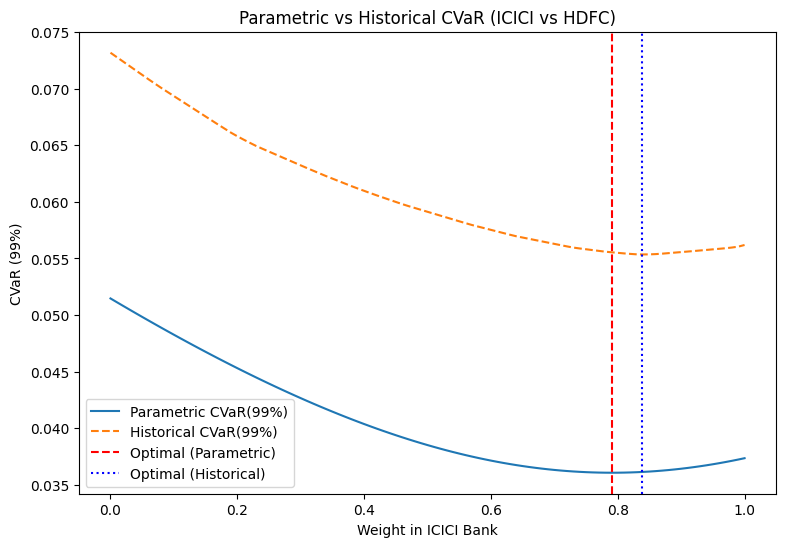

In [24]:
# Visualization: CVaR vs ICICI weight
ws = np.linspace(0, 1, 101)
cvars_param = []
cvars_hist = []

for w in ws:
    weights = np.array([w, 1-w])
    m, s = portfolio_stats(returns, weights)
    cvars_param.append(cvar_normal(m, s, 0.99))
    cvars_hist.append(cvar_historical(returns, weights, 0.99))

plt.figure(figsize=(9,6))
plt.plot(ws, cvars_param, label="Parametric CVaR(99%)")
plt.plot(ws, cvars_hist, label="Historical CVaR(99%)", linestyle="--")
plt.axvline(w_opt_param[0], color="red", linestyle="--", label="Optimal (Parametric)")
plt.axvline(w_opt_hist[0], color="blue", linestyle=":", label="Optimal (Historical)")
plt.xlabel("Weight in ICICI Bank")
plt.ylabel("CVaR (99%)")
plt.title("Parametric vs Historical CVaR (ICICI vs HDFC)")
plt.legend()
plt.show()